In [1]:
import pandas as pd
import numpy as np
import IPython.display as ipd
import wave
import librosa

# fastai repo, commit = 5906daacb43458e86754517b38840e4f2155141b

from fastai.learner import *
from fastai.dataset import *
from fastai.dataloader import *
torch.cuda.set_device(0)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%reload_ext jupyternotify
%autonotify -a 15

<IPython.core.display.Javascript object>

In [4]:
PATH = 'data/freesound'

In [5]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test = pd.read_csv(f'{PATH}/sample_submission.csv')

In [6]:
len(df_train.label.unique())

41

In [7]:
df_train['nframes'] = df_train.fname.apply(lambda f: wave.open(f'{PATH}/audio_train/{f}').getnframes())
df_test['nframes'] = df_test.fname.apply(lambda f: wave.open(f'{PATH}/audio_test/{f}').getnframes())

## Data, arch, loss

We need 3 things to build the classifier.
- Data : a dataloader that build Torch Tensors from Audio files
- arch : nn.Sequential, cf the kaggle kernel
- loss : F.cross_entropy

beware, F.cross_entropy already contains Softmax


### Data

In [8]:
BATCH_SIZE = 64

In [9]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, df, data_col, target_col=None, framerate=None):
        self.df = df
        self.data_col = data_col
        self.target_col = target_col
        self.framerate = framerate
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i): 
        data = self.df.iloc[i][self.data_col]
        
        input_length = 32000
        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")        
        
        return ( np.array(data), self.df.iloc[i][self.target_col] if self.target_col else 0 )

In [10]:
#this loads full audio data into the dataframe using librosa in multiprocessing
#mode since librosa.core.load is quite slow

#there is a bug somewhere in this code
#i had to run load_data_to_df 2 or 3 times for it to work. 

def chunkify(lst,n):
    return [lst[i::n] for i in range(n)]

def load_data_to_df(df):
    df['fulldata'] = None
    def process_chunk(chunk):
        for ix in tqdm_notebook(chunk):
            fn = df.loc[ix, 'fullpath']
            df.set_value(ix, 'fulldata', librosa.core.load(fn,16000)[0])     

    with ThreadPoolExecutor(16) as pool:
        chunks = chunkify(df.index, 16)
        pool.map(process_chunk, chunks)
        


In [11]:
df_train['fullpath'] = df_train.fname.apply(lambda fn: f'{PATH}/audio_train/{fn}')
df_train['label_code'] = df_train.label.astype('category').cat.codes
df_test['fullpath'] = df_test.fname.apply(lambda fn: f'{PATH}/audio_test/{fn}')
df_test['label_code'] = 0

readaudiofiles = False # activate this to read the wav files and convert them to numpy arrays

if readaudiofiles:
    load_data_to_df(df_train)
    load_data_to_df(df_test)


In [12]:
if readaudiofiles:
    for i, o in tqdm_notebook(df_train.iterrows()):
        np.save(o.fullpath+'.npy', o.fulldata)
    for i, o in tqdm_notebook(df_test.iterrows()):
        np.save(o.fullpath+'.npy', o.fulldata)

In [13]:
if not readaudiofiles:
    df_train['fulldata'] = df_train.fullpath.apply(lambda fn: np.load(fn+'.npy'))
    df_test['fulldata'] = df_test.fullpath.apply(lambda fn: np.load(fn+'.npy'))

In [14]:
def normalize(a):
    a -= a.mean()
    return a / abs(a).max()
df_test = df_test[df_test.nframes != 0]
df_train = df_train[df_train.nframes != 0]
df_test['fulldata'] = df_test.fulldata.apply(normalize)
df_train['fulldata'] = df_train.fulldata.apply(normalize)

In [15]:
idx = np.random.randn(len(df_train)) < 0.8

if idx.sum() % BATCH_SIZE == 1:
    idx[np.argmax(idx == False)] = True  # ensure there is no size 1 batch, else batchnorm crashes
df_trn = df_train[idx]
df_val = df_train[~idx]

In [16]:

ds_trn = AudioDataset(df_trn, 'fulldata', 'label_code', framerate=16000)
ds_val = AudioDataset(df_val, 'fulldata', 'label_code', framerate=16000)
ds_test = AudioDataset(df_test, 'fulldata', 'label_code', framerate=16000)

In [17]:
from fastai.text import SortishSampler
dl_trn = DataLoader(ds_trn, batch_size=BATCH_SIZE, shuffle=True)
#                    sampler=SortishSampler(ds_trn, key=lambda i: df_trn.iloc[i].nframes, bs=BATCH_SIZE))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
md = ModelData(PATH, dl_trn, dl_val, dl_test)

### Arch

from https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data

![img](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

In [19]:
def conv_block(in_channels, out_channels, kernel_size, maxpool_size, dropout=0):
    layers = [
        nn.Conv1d(in_channels, out_channels, kernel_size),
        nn.ReLU(),
        nn.Conv1d(out_channels, out_channels, kernel_size),
        nn.ReLU()#,nn.BatchNorm1d(out_channels)
    ]
    layers[0].weight.data.normal_(0, 0.1)
    layers[2].weight.data.normal_(0, 0.1)

    if maxpool_size:
        layers.append(nn.MaxPool1d(maxpool_size))
    else:
        layers.append(nn.AdaptiveMaxPool1d(1))
    if dropout:
        layers.append(nn.Dropout(p=dropout, inplace=True))
    return nn.Sequential(*layers)

def dense_block(l_channels, dropout=0):
    layers = [nn.Linear(l_channels[0], l_channels[1])]
    layers[-1].weight.data.normal_(0, 0.1)
    
    for in_channels, out_channels in zip(l_channels[1:], l_channels[2:]):
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_channels, out_channels))
        layers[-1].weight.data.normal_(0, 0.1)
        
    if dropout:
        layers.append(nn.Dropout(p=dropout))
    return nn.Sequential(*layers)

        
class Squeeze(nn.Module):
    def forward(self,x):
        return x.squeeze()
class Unsqueeze(nn.Module):
    def forward(self,x):
        return x.unsqueeze(1)
    
def audio_network(num_outputs):
    return nn.Sequential(
        Unsqueeze(),
        conv_block(1, 16, kernel_size=9, maxpool_size=16, dropout=0.1),
        conv_block(16, 32, kernel_size=3, maxpool_size=4, dropout=0.1),
        conv_block(32, 32, kernel_size=3, maxpool_size=4, dropout=0.1),
        conv_block(32, 256, kernel_size=3, maxpool_size=0, dropout=0.2),
        Squeeze(),
        dense_block([256, 64, 1024, num_outputs]))

In [20]:
model = audio_network(41)

In [21]:
model

Sequential(
  (0): Unsqueeze(
  )
  (1): Sequential(
    (0): Conv1d (1, 16, kernel_size=(9,), stride=(1,))
    (1): ReLU()
    (2): Conv1d (16, 16, kernel_size=(9,), stride=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace)
  )
  (2): Sequential(
    (0): Conv1d (16, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d (32, 32, kernel_size=(3,), stride=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace)
  )
  (3): Sequential(
    (0): Conv1d (32, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d (32, 32, kernel_size=(3,), stride=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace)
  )
  (4): Sequential(
    (0): Conv1d (32, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d (256,

In [22]:
from fastai.learner import Learner

In [23]:
learner = Learner(md, BasicModel(model.cuda()), optim.Adam, crit=F.cross_entropy)


In [24]:
learner.unfreeze()
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 92%|█████████▏| 107/116 [00:09<00:00, 11.21it/s, loss=39.2]


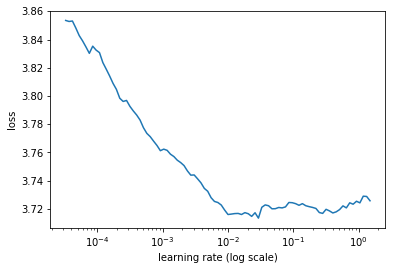

In [25]:
learner.sched.plot()

In [26]:
learner.fit(1e-3, 60) #, cycle_len=50, use_clr_beta=(10,10,0.95,0.85) )

HBox(children=(IntProgress(value=0, description='Epoch', max=60), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.481916   3.416773  
    1      3.288841   3.25675                               
    2      3.134792   3.063769                              
    3      2.833675   2.74247                               
    4      2.592194   2.524061                              
    5      2.421486   2.296652                              
    6      2.325725   2.317778                              
    7      2.236548   2.301839                              
    8      2.157139   2.108713                              
    9      2.058215   2.082207                              
    10     2.029629   2.010284                              
    11     1.926761   1.933143                              
    12     1.929279   1.916133                              
    13     1.851637   1.908919                              
    14     1.821068   1.880986                              
    15     1.762102   1.818842                      

[array([1.55894])]

<IPython.core.display.Javascript object>

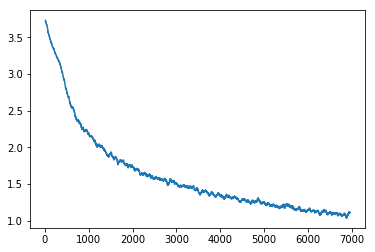

In [27]:
learner.sched.plot_loss()

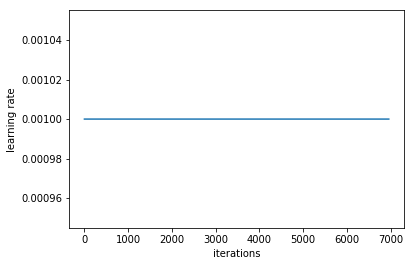

In [28]:
learner.sched.plot_lr()

In [29]:
learner.save('60epochs')

In [30]:
learner.model.eval()
o = learner.predict_with_targs()

In [31]:
accuracy_np(*o)

0.5692307692307692